In [2]:
import json
from pathlib import Path
from typing import List
import requests
import urllib.parse

from bs4 import BeautifulSoup
import feedparser
from weaviate.util import generate_uuid5
import weaviate

from src import rss_feed
from src import registry

%load_ext autoreload
%autoreload 1
%aimport src.registry

# Querying and parsing

In [2]:
def get_base_url(url) -> str:
    return urllib.parse.urlsplit(url).netloc

In [3]:
def get_links(filepath: str = "../data/links.txt") -> list:
    with open(filepath, "r", encoding="utf-8") as f:
        links = [line.strip() for line in f.readlines()]
    return links

def request_article(link: str):
    response = requests.get(link)
    html = response.text
    return html

def download_articles(urls: List[str], directory: str) -> None:
    for url in urls:
        html = request_article(url)
        write_html_to_file(f"{directory}/{url[-10:-1]}.html", html)

In [5]:
def write_html_to_file(filepath: str, html) -> None:
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(html)

def read_html_from_file(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        html = f.read()
    return html

def read_articles(dirpath: str) -> str:
    dirpath = Path(dirpath)
    for file in dirpath.iterdir():
        if file.suffix == ".html":
            html = read_html_from_file(file)
            yield html

In [4]:
def parse_source(html) -> str:
    def _site_match_func(tag):
        if tag.name == "meta":
            if tag.get("name") == "og:site_name":
                return True
            elif tag.get("property") == "og:site_name":
                return True
        else:
            return False

    soup = BeautifulSoup(html)
    if results := soup.head.find_all(_site_match_func):
        source = results[0]["content"]
    else:
        source = []
    return source

In [5]:
from src.parsers import parser_summary, parser_title, parser_paragraphs, parser_source

def create_article_obj(soup: BeautifulSoup) -> dict:
    article_obj = dict(
        title=parser_title(soup),
        summary=parser_summary(soup),
        source=""
    )
    return article_obj

In [16]:
download_articles(get_links(), "../data/articles")

In [6]:
soups = [BeautifulSoup(h) for h in read_articles("../data/articles")]
all_objs = [create_article_obj(s) for s in soups]

In [26]:
def parse_title(soup, cfg):
    import src.parsers.title as title_parser

    parse_func = getattr(title_parser, cfg.title)
    result = parse_func(soup)
    return result

In [27]:
result = parse_title(soups[0], cfg.parser)

In [59]:
import src.parsers.title as title_parser
parse_func = getattr(title_parser, "title__text")
parse_func(soups[6])

'Introduction to streaming for data scientists'

# Dealing with RSS
ref: https://validator.w3.org/feed/docs/rss2.html#whatIsRss

- RSS comes in various versions, including 0.91, 0.92, 2.0, and 2.0.1
- each link has a main \<channel\> object, and a number of \<items\>
- historical items out of the stack are no longer accessible (need to store them)

## Channel schema
### Mandatory
- title: name of the channel; should match the website name
- link: url of the HTML page
- description: description of the channel, i.e., the website
### Optional
- language: language of the channel content
- cloud: if there exist a pub-sub protocol to receive updates (https://validator.w3.org/feed/docs/rss2.html#ltcloudgtSubelementOfLtchannelgt)


## Item schema
- all elements are optional, but there needs to be at least a title or description
- title
- link
- description
- author
- category
- comments
- pubDate

In [5]:
def find_feed_url(url: str):
    response = rss_feed.get_page(url)
    xml = rss_feed.response_to_xml(response)
    urls = rss_feed.query_xml(xml)
    parsed_urls = rss_feed.parse_urls(urls)
    feed_url = rss_feed.filter_feed_url(parsed_urls)

    return feed_url

In [6]:
def resolve_feed_url(feed_url, base_url) -> str:
    if not feed_url.netloc:
        string_feed_url = rss_feed.unparse_url(feed_url, base_url)
    else:
        string_feed_url = rss_feed.unparse_url(feed_url)

    return string_feed_url

## Register feeds

In [9]:
registry_conn = registry.connect_to_db("../data/registry.sqlite")
registry.create_rss_feed_table(registry_conn)
sources = get_links("../data/sources.txt")

In [8]:
for url in sources:
    feed_url = find_feed_url(url)
    if feed_url is None:
        continue

    feed_url = resolve_feed_url(feed_url, url)
    feed = feedparser.parse(feed_url)

    registry.insert_rss_feed(registry_conn, feed_url, feed.feed.title, feed.version)

## Retrieve entries

In [18]:
registry_conn = registry.connect_to_db("../data/registry.sqlite")
registry.create_article_table(registry_conn)
feed_objs = registry.read_rss_feed(registry_conn)

In [20]:
for feed_obj in feed_objs:
    feed_url = feed_obj[1]
    feed = feedparser.parse(feed_url)
    for entry in feed.entries:
        registry.insert_article(registry_conn, feed_url, entry.link, entry.title)

# Weaviate

In [3]:
def load_schema_classes(schema_path) -> dict:
    schema_path = Path(schema_path)

    schema_classes = dict(classes=[])
    for file in schema_path.iterdir():
        if file.suffix == ".json":
            with open(file) as f:
                schema = json.load(f)
                schema_classes["classes"].append(schema)

    return schema_classes

def get_article_paragraphs(url):
    entry_page = rss_feed.get_page(url)
    entry_soup = BeautifulSoup(entry_page.content, features="lxml", parser="lxml")
    if entry_soup.article:
        return [p.text for p in entry_soup.article.find_all("p")]
    else:
        return []

In [4]:
registry_conn = registry.connect_to_db("../data/registry.sqlite")
registry.create_weaviate_table(registry_conn)
feed_objs = registry.read_rss_feed(registry_conn)

wclient = weaviate.client.Client(url="http://localhost:8080")
wclient.schema.delete_all()
schemas = load_schema_classes("../schema")
wclient.schema.create(schemas)

In [5]:
for feed_obj in feed_objs:
    feed_url = feed_obj[1]
    feed = feedparser.parse(feed_url)
    for entry in feed.entries:
        with wclient.batch() as batch:
            article_obj = rss_feed.parse_entry(entry)
            article_obj["source_link"] = feed_url
            article_uuid = generate_uuid5(article_obj, "Article")

            batch.add_data_object(data_object=article_obj, class_name="Article", uuid=article_uuid)

            for idx, paragraph in enumerate(get_article_paragraphs(article_obj["link"])):
                paragraph_obj = dict(index=idx, content=paragraph)
                paragraph_uuid = generate_uuid5(paragraph_obj, "Paragraph")
                batch.add_data_object(data_object=paragraph_obj, class_name="Paragraph", uuid=paragraph_uuid)

                batch.add_reference(article_uuid, "Article", "hasParagraphs", paragraph_uuid, "Paragraph")
                batch.add_reference(article_uuid, "Paragraph", "fromArticle", article_uuid, "Article")

        registry.insert_weaviate(registry_conn, entry.link, article_uuid)

# Plotting TSNE

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
json_out = []

In [63]:
titles = []
xs = []
ys = []
for a in json_out["data"]["Get"]["Article"]:
    titles.append(a["title"])
    vector = a["_additional"]["featureProjection"]["vector"]
    xs.append(vector[0])
    ys.append(vector[1])

In [66]:
df = pd.DataFrame([titles, xs, ys]).T

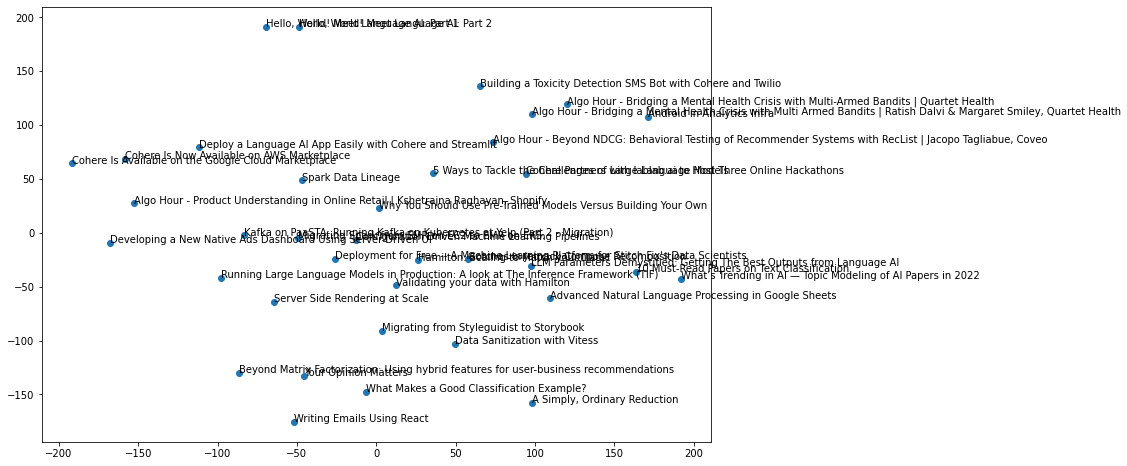

In [76]:
plt.rcParams["figure.figsize"] = (12, 8)

fig, ax = plt.subplots()
ax.scatter(df[1], df[2])

for i in df.index:
    ax.annotate(df.iloc[i, 0], (df.iloc[i, 1], df.iloc[i, 2]))